In [92]:
import pandas as pd
import data_collection as dc
import prediction_model as pm
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import datetime

In [93]:
def add_lag_diff(df, begin, end, interval, dropna=True):
    df_lag = df.copy()
    columns = df.columns
    for column in columns:
        if column.lower() == 'date':
            continue
        for i in range(begin, end, interval):
            df_lag[f'{column}_{i}_lag'] = df_lag[column].shift(i)  # lags in days
            df_lag[f'{column}_{i}_diff'] = df_lag[f'{column}_{i}_lag'].diff()  # difference
    return df_lag.dropna() if dropna else df_lag

In [94]:
geo = "BE"
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/be-covid-hospi.csv"
full_df = pm.create_df_trends_url(url_hospi, geo)
full_data, full_data_no_rolling = pm.google_trends_process(full_df, pm.list_topics, start_year=2020, start_mon=2,
                                                           stop_year=2020,
                                                          stop_mon=9, step=1, data_collection=False)
shifted_df = add_lag_diff(full_data, 7, 14, 1)
shifted_df = shifted_df.reset_index().set_index('DATE')
shifted_df = shifted_df.drop(columns=['LOC'])
shifted_df

DL BE Fièvre
DL BE Mal de gorge
DL BE Dyspnée
DL BE Agueusie
DL BE Anosmie
DL BE Coronavirus
DL BE Virus
DL BE Température corporelle humaine
DL BE Épidémie
DL BE Symptôme
DL BE Thermomètre
DL BE Grippe espagnole
DL BE Paracétamol
DL BE Respiration
DL BE Toux


,Fièvre,Mal de gorge,Dyspnée,Agueusie,Anosmie,Coronavirus,Virus,Température corporelle humaine,Épidémie,Symptôme,...,HOSP_CORR_9_lag,HOSP_CORR_9_diff,HOSP_CORR_10_lag,HOSP_CORR_10_diff,HOSP_CORR_11_lag,HOSP_CORR_11_diff,HOSP_CORR_12_lag,HOSP_CORR_12_diff,HOSP_CORR_13_lag,HOSP_CORR_13_diff
DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.875211,0.666075,1.000000,-0.054230,-0.030120,0.709091,0.609756,0.513514,0.596522,0.615764,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-19,0.726813,0.531083,0.712984,0.162690,0.337349,0.619835,0.480836,0.243243,0.506087,0.467980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-20,0.591906,0.460036,0.485194,0.158351,0.638554,0.533884,0.393728,0.360360,0.426087,0.313629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-21,0.433390,0.349911,0.271071,0.353579,0.795181,0.441322,0.306620,0.346847,0.370435,0.218391,...,0.018057,0.018057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-22,0.328836,0.275311,0.271071,0.644252,0.921687,0.368595,0.236934,0.247748,0.325217,0.175698,...,0.040946,0.022889,0.018057,0.018057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,-0.541315,-0.268206,-0.553531,-0.704989,-0.584337,-0.791736,-0.905923,-0.639640,-0.892174,-0.448276,...,0.068667,0.006104,0.062564,0.004832,0.057731,0.001780,0.055951,0.001780,0.054171,0.006867
2020-09-24,-0.548061,-0.243339,-0.585421,-0.704989,-0.644578,-0.801653,-0.905923,-0.639640,-0.881739,-0.474548,...,0.073754,0.005086,0.068667,0.006104,0.062564,0.004832,0.057731,0.001780,0.055951,0.001780
2020-09-25,-0.585160,-0.268206,-0.512528,-0.613883,-0.644578,-0.804959,-0.909408,-0.716216,-0.881739,-0.490969,...,0.079095,0.005341,0.073754,0.005086,0.068667,0.006104,0.062564,0.004832,0.057731,0.001780


In [95]:
X_train = shifted_df[:'2020-09-15'].drop(['HOSP_CORR'], axis = 1)
y_train = shifted_df.loc[:'2020-09-15', 'HOSP_CORR']
X_test = shifted_df['2020-09-16':].drop(['HOSP_CORR'], axis = 1)
y_test = shifted_df.loc['2020-09-16':, 'HOSP_CORR']

In [96]:
models = []
models.append(('LR', LinearRegression()))
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LR: -0.048522 (0.038624)


(178.0, 193.0)

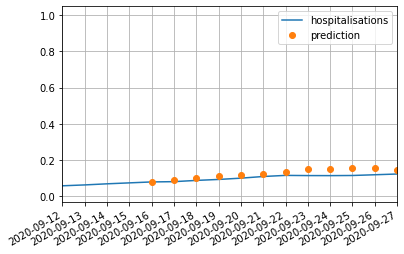

In [102]:
pred = models[0][1].fit(X_train, y_train)
x = pd.concat([X_train, X_test], axis=1).index
y = pd.concat([y_train, y_test], axis=0)
x_pred = X_test.index
y_pred = pred.predict(X_test)
# plot the actual hospitalisations and predictions
fig = plt.figure()
plt.plot(x, y, label='hospitalisations')
plt.plot(x_pred, y_pred, 'o', label='prediction')
plt.grid()
plt.legend()
x_max = str(datetime.datetime.strptime(x_pred.max(), '%Y-%m-%d').date())
delay = datetime.timedelta(days = 15)
x_min = str((datetime.datetime.strptime(x.max(), '%Y-%m-%d') - delay).date())
fig.autofmt_xdate()
plt.xlim([x_min, x_max])